## IMPORTS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nmeso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## EXPLORATORY DATA ANALYSIS
> Reading the data, checking for null values

In [2]:
df = pd.read_csv('2020-09-01-2021-10-20-Western_Africa-Nigeria.csv')

In [21]:
df.head(2)

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,...,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,8605439,566,NIG22328,22328,20 October 2021,2021,1,Protests,Peaceful protest,Protesters (Nigeria),...,Abuja,9.0833,7.5333,1,The Cable (Nigeria); New Telegraph; Daily Inde...,National,"On 20 October 2021, a group of government supp...",0,1635193320,NGA
1,8605440,566,NIG22329,22329,20 October 2021,2021,1,Protests,Peaceful protest,Protesters (Nigeria),...,Akure,7.2526,5.1931,1,Business Day (Nigeria); New Telegraph,National,"On 20 October 2021, youths staged a memorial #...",0,1635193320,NGA


In [ ]:
df.isnull().sum()

For the analysis of df, I am only interested in the following features.
`['event_date','year','event_type','sub_event_type','region','country','location','source','notes','fatalities']`

Analyzing this text data using natural language processing, since the file contains some metadata such as id's and filenames, it is necessary to remove all the columns that do not contain useful text information.To do this, I am creating a new dataframe `new_df` hsving only the preferres features

In [4]:
new_df = df[['event_date','year','event_type','sub_event_type',
           'region','country','location','source','notes','fatalities']]

In [5]:
new_df.head(3)

,event_date,year,event_type,sub_event_type,region,country,location,source,notes,fatalities
0,20 October 2021,2021,Protests,Peaceful protest,Western Africa,Nigeria,Abuja,The Cable (Nigeria); New Telegraph; Daily Inde...,"On 20 October 2021, a group of government supp...",0
1,20 October 2021,2021,Protests,Peaceful protest,Western Africa,Nigeria,Akure,Business Day (Nigeria); New Telegraph,"On 20 October 2021, youths staged a memorial #...",0
2,20 October 2021,2021,Protests,Peaceful protest,Western Africa,Nigeria,Benin City,Business Day (Nigeria); New Telegraph; Daily I...,"On 20 October 2021, youths and members of the ...",0


In order to know what is prone to occur more, I will begin by visualizing the number of incidents per incident type.

By looking at this visualization, we can understand the extent of violence against civilians in Nigeria.

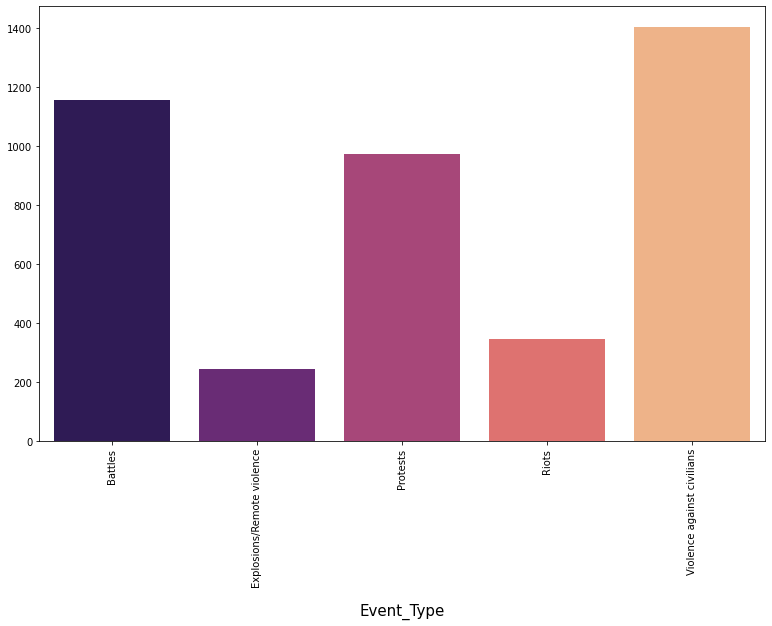

In [26]:
groups = new_df.groupby('event_type')
counts = groups.size()

plt.figure(figsize = (13, 8))
ax = sns.barplot(counts.index, counts.values, palette=("magma"))
ax.set_xlabel("Event_Type",fontsize = 15, labelpad = 15)
plt.xticks(rotation = 90)
plt.show()

In [7]:
import re
new_df['notes'].head()

new_df['notes_processed'] = new_df['notes'].map(lambda x: re.sub('[,\.!?]', '', x))
new_df['notes_processed'] = new_df['notes_processed'].map(str.lower)

new_df['notes_processed'].head()

C:\Users\Nmeso\AppData\Local\Temp/ipykernel_16036/4187992845.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['notes_processed'] = new_df['notes'].map(lambda x: re.sub('[,\.!?]', '', x))
C:\Users\Nmeso\AppData\Local\Temp/ipykernel_16036/4187992845.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['notes_processed'] = new_df['notes_processed'].map(str.lower)


0    on 20 october 2021 a group of government suppo...
1    on 20 october 2021 youths staged a memorial #e...
2    on 20 october 2021 youths and members of the c...
3    on 20 october 2021 hundreds of women protestin...
4    on 20 october 2021 gungura and buri-buri milit...
Name: notes_processed, dtype: object

WordCloud is a technique to show which words are the most frequent among the given text. Visualizing the most frequent words from the cleaned text,

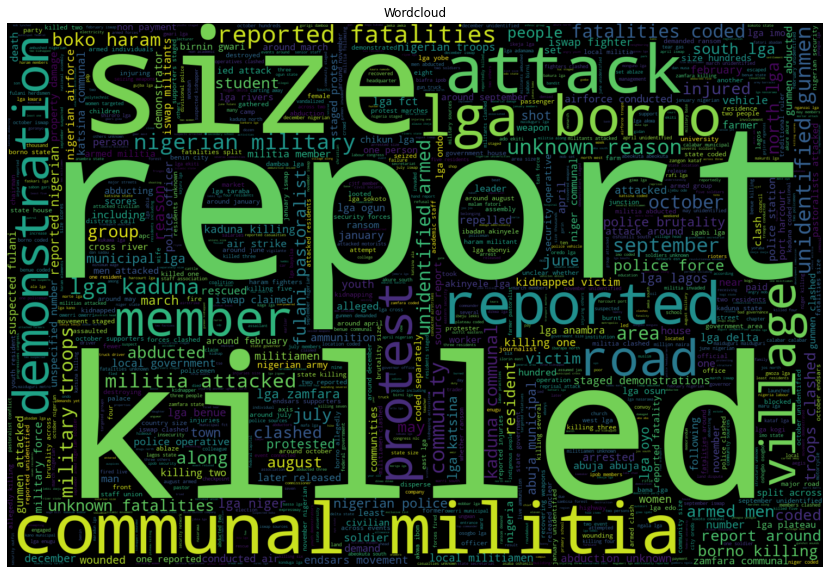

In [20]:
from wordcloud import WordCloud

def plot_wordcloud(df):
    '''function to plot wordcloud from a given dataframe'''
    plt.figure(figsize = (20,10))
    wc = WordCloud(width = 1500,height = 1000,max_words = 1000).generate(' '.join(word for word in df))
    plt.axis("off")
    plt.title('Wordcloud')
    plt.imshow(wc , interpolation = 'bilinear')

plot_wordcloud(new_df.notes_processed)

### Text Analysis

The main text analysis method that I will use is latent Dirichlet allocation (LDA). LDA is able to perform topic detection on large document sets, determining what the main 'topics' are in a large unlabeled set of texts. 

A 'topic' is a collection of words that tend to co-occur often. The hypothesis is that LDA might be able to clarify what the different topics in the research titles are. These topics can then be used as a starting point for further analysis.

LDA does not work directly on text data. First, it is necessary to convert the documents into a simple vector representation. This representation will then be used by LDA to determine the topics. Each entry of a 'document vector' will correspond with the number of times a word occurred in the document. In conclusion, I will convert a list of titles into a list of vectors, all with length equal to the vocabulary. For example, 'Analyzing machine learning trends with neural networks.' would be transformed into [1, 0, 1, ..., 1, 0].

I'll then plot the 20 most common words based on the outcome of this operation (the list of document vectors).

C:\Users\Nmeso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


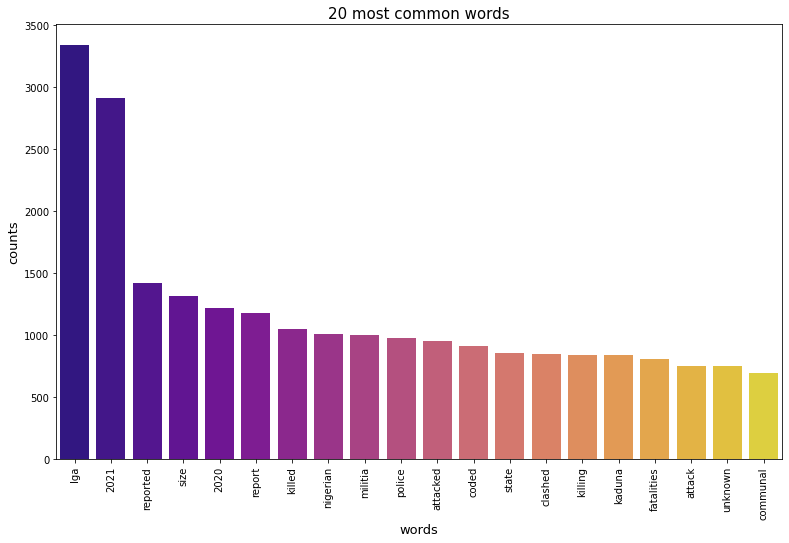

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_20_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
    words = [w[0] for w in count_dict[0:20]]
    counts = [w[1] for w in count_dict[0:20]]
    x_pos = np.arange(len(words))

    sns.barplot(x_pos, counts, palette=("plasma"))
    plt.xticks(x_pos, words, rotation = 90) 
    plt.xlabel('words', fontsize = 13)
    plt.ylabel('counts', fontsize = 13)
    plt.title('20 most common words', fontsize = 15)
    plt.show()
    
    return dict(count_dict)

count_vectorizer = CountVectorizer(stop_words = 'english')
count_data = count_vectorizer.fit_transform(new_df['notes_processed'])

plt.figure(figsize = (13, 8))
count_dict = plot_20_most_common_words(count_data, count_vectorizer)


Since most cells in the matrix count_data will be zero, I am interested in knowing what percentage of cells contain non-zero values. Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix.

In [10]:
data_dense = count_data.todense()
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.31544171770327245 %


### Latent Dirichlet Allocation and GridSearch
While there are many different analyses one can do using LDA, I will only focus on finding the optimal number of topics from this data.

Typically, one calculates the 'perplexity' metric to determine which number of topics is best and iterate over different amounts of topics until the lowest 'perplexity' is found. A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

To find the best model, I will use GridSearch. The most important tuning parameter for LDA models is n_components (number of topics). The grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.simplefilter("ignore", FutureWarning)

search_params = {'n_components': [20, 25, 30, 35], 'max_iter': [10, 20, 50]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, cv = None, param_grid = search_params)
model.fit(count_data)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'max_iter': [10, 20, 50],
                         'n_components': [20, 25, 30, 35]})

In [12]:
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(count_data))

Best Model's Params:  {'max_iter': 50, 'n_components': 20}
Best Log Likelihood Score:  -187292.1655661506
Model Perplexity:  694.5991629185196


As a last step, I will plot the log-likelihood scores against num_topics. It clearly shows number of topics = 20 has better scores. And max_iter of 50 outperforms both 10 and 20.

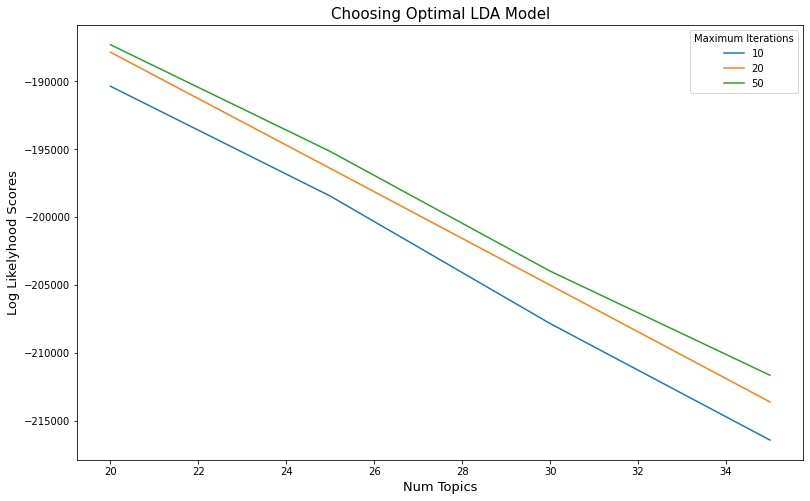

In [13]:
n_topics = [20, 25, 30, 35]
results = pd.DataFrame(model.cv_results_)
logl_10 = (results['mean_test_score'][i] for i in range(len(results)) if results['params'][i]['max_iter'] == 10)
logl_20 = (results['mean_test_score'][i] for i in range(len(results)) if results['params'][i]['max_iter'] == 20)
logl_50 = (results['mean_test_score'][i] for i in range(len(results)) if results['params'][i]['max_iter'] == 50)

plt.figure(figsize=(13, 8))
sns.lineplot(n_topics, list(logl_10), label='10')
sns.lineplot(n_topics, list(logl_20), label='20')
sns.lineplot(n_topics, list(logl_50), label='50')
plt.title("Choosing Optimal LDA Model", fontsize = 15)
plt.xlabel("Num Topics", fontsize = 13)
plt.ylabel("Log Likelyhood Scores", fontsize = 13)
plt.legend(title='Maximum Iterations', loc = 'best')
plt.show()

Data Visualization for Topic modelling:

In [27]:
# !pip install pyLDAvis

In [18]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, count_data, count_vectorizer, mds='tsne')
saved = pyLDAvis.save_html(vis, fileobj = "vis.html")

In [19]:
vis

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
5      -10.878068   10.538728       1        1  10.775119
14     -60.884026  -75.591820       2        1  10.477871
18      -2.336119  -53.289074       3        1   9.192701
9      -61.385319  -12.914634       4        1   8.907058
11     -28.737743  126.296997       5        1   7.403242
2        1.066606 -123.552811       6        1   6.823645
13      45.140720   -7.947869       7        1   6.268471
4     -140.795975  -98.530548       8        1   5.810570
17      61.531681  -83.240562       9        1   5.760600
16     -72.563057 -140.396881      10        1   5.345962
12      15.984491   63.578186      11        1   4.167335
15    -160.851624   68.945145      12        1   3.488963
1       85.961830   51.922935      13        1   2.819396
19     -99.020836  109.936348      14        1   2.739033
0     -176.764130   -8.681684      15        1   2.392638
8     -117.189880  -37.420200      16        1   2.279878
10     108.829918  -22.946203      17        1   1.743838
3       47.588097  121.934814      18        1   1.544613
7     -106.467834   30.176889      19        1   1.382972
6      -50.613804   59.328842      20        1   0.676094, topic_info=            Term         Freq        Total Category  logprob  loglift
3380      kaduna   787.000000   787.000000  Default  30.0000  30.0000
5466      report  1099.000000  1099.000000  Default  29.0000  29.0000
5899        size  1241.000000  1241.000000  Default  28.0000  28.0000
5158      police   917.000000   917.000000  Default  27.0000  27.0000
1053       borno   596.000000   596.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4109    material     3.088922    15.966447  Topic20  -5.3622   3.3539
2587       group     4.378642   320.623300  Topic20  -5.0133   0.7031
28            17     3.382730   161.269590  Topic20  -5.2713   1.1322
1272  checkpoint     2.708673    42.328199  Topic20  -5.4936   2.2476
3689       kwali     2.525783    13.666658  Topic20  -5.5635   3.3082

[1218 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3         1  0.308869       10
3         2  0.055438       10
3         3  0.110876       10
3         4  0.071277       10
3         5  0.083157       10
...     ...       ...      ...
6857      5  0.086712   zangon
6857     15  0.086712   zangon
6861      7  0.977026    zaria
6877      3  0.943679   zonkwa
6882     11  0.862140  zungeru

[2215 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 15, 19, 10, 12, 3, 14, 5, 18, 17, 13, 16, 2, 20, 1, 9, 11, 4, 8, 7])

In [28]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

# topics = best_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


AttributeError: 'LatentDirichletAllocation' object has no attribute 'show_topics'